In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
config = {
    'domain': 'protein',
    'postgres': False,
    'debug': False,
    'babbler_candidate_split': 1,
    'babbler_label_split': 1,
    'supervision': 'traditional',
    'traditional_split': 1,
    'disc_model_class': 'logreg',    
}

In [3]:
# Get DB connection string and add to globals
# NOTE: $SNORKELDB must be set before any snorkel imports
import os

default_db_name = 'babble_' + config['domain'] + ('_debug' if config.get('debug', False) else '')
DB_NAME = config.get('db_name', default_db_name)
if 'postgres' in config and config['postgres']:
    DB_TYPE = 'postgres'
else:
    DB_TYPE = 'sqlite'
    DB_NAME += '.db'
DB_ADDR = "localhost:{0}".format(config['db_port']) if 'db_port' in config else ""
os.environ['SNORKELDB'] = '{0}://{1}/{2}'.format(DB_TYPE, DB_ADDR, DB_NAME)
print("$SNORKELDB = {0}".format(os.environ['SNORKELDB']))

$SNORKELDB = sqlite:///babble_protein.db


In [4]:
from snorkel import SnorkelSession
session = SnorkelSession()

# Resolve config conflicts (nb_config > local_config > global_config)
from snorkel.contrib.babble.pipelines import merge_configs, get_local_pipeline
config = merge_configs(config)

if config['debug']:
    print("NOTE: --debug=True: modifying parameters...")
    config['max_docs'] = 100
    config['gen_model_search_space'] = 1
    config['disc_model_search_space'] = 1
    config['gen_params_default']['epochs'] = 25
    config['disc_params_default']['n_epochs'] = 5

from snorkel.models import candidate_subclass
candidate_class = candidate_subclass(config['candidate_name'], config['candidate_entities'])

pipeline = get_local_pipeline(config['domain'])
pipe = pipeline(session, candidate_class, config)

Overwriting domain=None to domain=protein
Overwriting disc_model_class=lstm to disc_model_class=logreg
Overwriting supervision=generative to supervision=traditional
Overwriting traditional_split=0 to traditional_split=1


In [ ]:
%time pipe.parse()

In [ ]:
%time pipe.extract()

In [ ]:
%time pipe.load_gold()

In [ ]:
%time pipe.featurize()

In [ ]:
%time pipe.collect()

In [ ]:
pipe.babbler.filtered_analysis()

In [ ]:
%time pipe.label()

In [5]:
%time pipe.supervise()

In 'traditional' supervision mode...skipping 'supervise' stage.
CPU times: user 359 µs, sys: 220 µs, total: 579 µs
Wall time: 428 µs


In 'traditional' supervision mode...grabbing candidate and gold label subsets.
NOTE: using split 1 for traditional supervision. Be aware of unfair evaluation.
NOTE: traditional supervision helper assumes all candidates have labels.
No value found for max_train. Using all available gold labels.
Using 1168 traditional gold labels
(1168,)


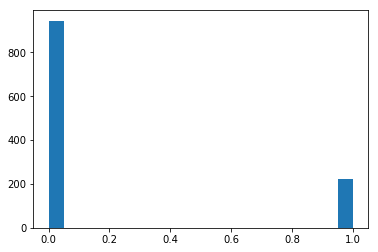

### [7.1] Begin training discriminative model
[1] Testing dim = 64, dropout = 2.50e-01, rebalance = 0.00e+00, lr = 1.00e-03
[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=1168  #epochs=20  batch size=128
[SparseLogisticRegression] Epoch 0 (0.05s)	Average loss=0.753161	Dev F1=31.51
[SparseLogisticRegression] Epoch 1 (0.14s)	Average loss=0.667256	Dev F1=33.03
[SparseLogisticRegression] Epoch 2 (0.21s)	Average loss=0.614904	Dev F1=34.81
[SparseLogisticRegression] Epoch 3 (0.29s)	Average loss=0.555658	Dev F1=36.36
[SparseLogisticRegression] Epoch 4 (0.37s)	Average loss=0.514127	Dev F1=38.66
[SparseLogisticRegression] Epoch 5 (0.45s)	Average loss=0.481751	Dev F1=36.68
[SparseLogisticRegression] Epoch 6 (0.53s)	Average loss=0.464190	Dev F1=38.18
[SparseLogisticRegression] Epoch 7 (0.61s)	Average loss=0.430826	Dev F1=38.73
[SparseLogisticRegression] Epoch 8 (0.69s)	Average loss=0.425461	Dev F1=39.74
[SparseLogisticRegression] Epoch 9 (0.77s)	Average loss=0.397043

In [6]:
%time pipe.classify()